In [1]:
#Import the Libraries
import math
import numpy as np
from numpy.fft import ifft
import matplotlib.pyplot as plt

In [50]:
#Inputs from the user
nan = math.nan
loop = True
Nrb_table = np.array([[25, 52, 79, 106, 133, 160, 216, 270, nan, nan, nan, nan],
                      [11, 24, 38, 51, 65, 78, 106, 133, 162, 217, 245, 273],
                      [nan, 11, 18, 24, 31, 38, 51, 65, 79, 107, 121, 135]])      #Number of resource block table
scs_range = 1e3* np.array([15, 30, 60])                                           #subcarrier spacing range 
bandwidth_range = 1e6* np.array([5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 90, 100]) #Bandwidth range between 5MHz and 100MHz


#Get the values of the SCS and Bandwidth
while loop == True:
  scs, bandwidth = map(float, input("Enter a value for subcarrier spacing and bandwidth: ").split())
  if ((scs in scs_range) and (bandwidth in bandwidth_range)):
    Nrb = Nrb_table[np.where(scs_range==scs), np.where(bandwidth_range==bandwidth)]#Get the nrb value for the specified scs and bandwidth
    if np.isnan(Nrb):
      print("Enter a valid (scs, bandwidth) pair for which Nrb is not nan")
    else:
      loop = False
  else:
    print("Choose values for scs and bandwidth from the following list")
    print("SCS values: ", scs_range)
    print("Bandwidth_range: ", bandwidth_range)


#Get the desired modulation scheme
print("Select a modulation scheme from the following: ")
print("1. QPSK")
print("2. 16QAM")
print("3. 64QAM")
mod_type = input()                                                                          # Get the type of modulation scheme to be used
M_dict = {"QPSK": 4,  "16QAM": 16,  "64QAM": 64}                                            # Dictionary containing the M values for each modulation type
M = M_dict[mod_type]                                                                        # M value of the modulation scheme selected

#Predefined parameters
P_tx = 40                                                                                   # Transmitter power
mu = np.where(scs_range==scs)[0][0]                                                         # Determines the number of slots in a subframe
N_fft = 4096                                                                                # Number of fft taps in 5G
N_subcar = int(Nrb[0, 0] * 12)                                                              # Number of subcarriers per OFDM symbol
N_frames = 100                                                                              # Total number of frames
N_subframes = 10                                                                            # Number of subframes per frame
N_slots = (2**mu)                                                                           # Number of slots in a subframe
N_ofdm_symbols = 14                                                                         # Number of ofdm symbols per slot
Total_bits = N_subcar* math.log(M, 2)* N_ofdm_symbols* N_slots* N_subframes* N_frames       # Total number of bits generated

Enter a value for subcarrier spacing and bandwidth: 30000 100.0e+06
Select a modulation scheme from the following: 
1. QPSK
2. 16QAM
3. 64QAM
64QAM


Frame 0 finished
Frame 10 finished
Frame 20 finished
Frame 30 finished
Frame 40 finished
Frame 50 finished
Frame 60 finished
Frame 70 finished
Frame 80 finished
Frame 90 finished


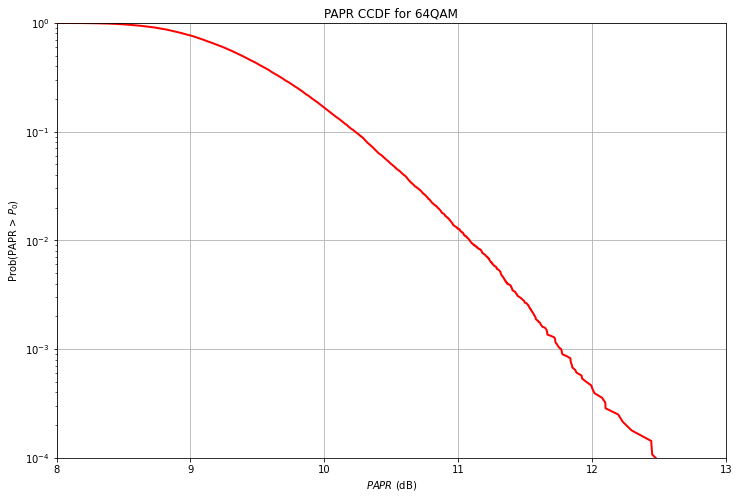

In [51]:
#Pre-allocating papr vector with zero values
papr = np.zeros(N_frames* N_subframes* N_slots* N_ofdm_symbols)
ppr = np.zeros(N_frames* N_subframes* N_slots* N_ofdm_symbols)
avg_pr = np.zeros(N_frames* N_subframes* N_slots* N_ofdm_symbols)

def ppr_ccdf(ppr):
  bins = np.sort(ppr)
  cdf  = np.linspace(0,1,len(bins),endpoint=False)
  ccdf = 1 - cdf
  return [bins, ccdf]

p = 0

#Loop over each OFDM symbol
for frame in range(N_frames):
  if frame%10 == 0:
    print("Frame", frame, "finished")
  for subframe in range(N_subframes):
    for slot in range(N_slots):
      for symbol in range(N_ofdm_symbols):
        N_bits = int(math.log(M, 2)* N_fft)
        
        # Generating a new OFDM symbol in each iteration of the loop
        x_data = np.random.randint(2, size = N_bits)
        modulated_sym = np.zeros((1, N_fft), dtype='complex_')
        
        # Performing the desired modulation scheme on each OFDM symbol
        if mod_type == 'QPSK':
          for i in range(N_fft):
            modulated_sym[0, i] = (1/np.sqrt(2))*((1-2*x_data[2*i])+ (1j*(1-2*x_data[(2*i)+1])))
        elif mod_type == '16QAM':
          for i in range(N_fft):
            modulated_sym[0, i] = (1/np.sqrt(10))*((1-2*x_data[4*i])*(2-(1-2*x_data[(4*i)+2]))+ (1j*(1-2*x_data[(4*i)+1])*(2-(1-2*x_data[(4*i)+3]))))
        elif mod_type == '64QAM':
          for i in range(N_fft):
            modulated_sym[0, i] = (1/np.sqrt(42))*((1-2*x_data[6*i])*(4-(1- 2*x_data[(6*i)+2])*(2-(1-2*x_data[(6*i)+4]))) + (1j*(1-2*x_data[(6*i)+1])*(4-(1- 2*x_data[(6*i)+3])*(2-(1-2*x_data[(6*i)+5])))))
        
        # Performing IFFT on the modulated OFDM symbols
        x_n = ifft(modulated_sym, norm= 'ortho')

        #Calculation of length of cyclic prefix
        if symbol == 0 or symbol == 7*N_slots:
          cp_length = (288 + 162**(mu+1))
        else:
          cp_length = 288
        
        #Adding the cyclic prefix to the OFDM symbols
        x_n_with_cp = np.append(x_n[-cp_length:],x_n)

        #Calculation of the power of the given symbol
        ppr[p] = np.max(np.abs(x_n_with_cp)**2)
        avg_pr[p] = np.mean(np.abs(x_n_with_cp)**2)
        papr[p] = ppr[p]/avg_pr[p]
        p += 1

r,ccdf = ppr_ccdf(papr)

plt.rcParams['figure.figsize'] = [12, 8]
plt.semilogy(10*np.log10(r), ccdf,'r',lw=2 )
plt.xlabel(r'$PAPR$ (dB)')
plt.ylabel(r'Prob(PAPR > $P_0$)')
plt.axis([8,13,1e-4,1])
plt.grid(True)
plt.title('PAPR CCDF for ' + str(mod_type))
plt.show()

In [52]:
n_symbols_per_1ms_subframe = N_slots* N_ofdm_symbols                                  # Number of OFDM symbols in a subframe
Tc = 1/(scs * N_fft)                                                                  # basic unit of 5G
Ts = 1/(15.0e+03 * 2048)                                                              # sampling period of 4G LTE
kappa = Ts/Tc                                                                         # relationship between Ts and Tc
fsamp = 1/(Tc*1e6)                                                                    # sampling rate of 5G
occ_bandwidth = ((Nrb[0][0]* scs* 12)+ scs)/1000000                                   # the occupied bandwidth in MHz
cp_long = (288 + 16*2**(mu+1))                                                        # the length of the longest cyclic prefix
cp_short = 288                                                                        # the length of the shortest cyclic prefix
max_papr = max(papr)                                                                  # the maximal peak to average power ratio
avg_power = np.mean(avg_pr)* P_tx                                                     # Average simulated power
prob = 0.0001
papr_at_prob = 10*np.log10(r[np.where(ccdf==min(ccdf[np.where(ccdf<=prob)]))[0][0]])

# Printing the numerical outputs
print("Average Simulated power: {:3.4f}".format(avg_power))
print("Maximal PAPR: {:3.4f} (linear)".format(max_papr))
print("OFDM data length: {}".format(int(Total_bits)))
print("PAPR at 0.0001 probablity: {:3.3f} dB".format(papr_at_prob))
print("Occupied Bandwidth: {} MHz, Basic unit in 5G, Tc: {:5.4f} ns, sampling rate: {} Msps". format(occ_bandwidth, 1e9*Tc, fsamp))
print("kappa: {}, CP_Long: {}, CP_short: {}". format(kappa, cp_long, cp_short))
print("Number of ofdm symbols in a 1ms subframe:", n_symbols_per_1ms_subframe)

Average Simulated power: 40.0010
Maximal PAPR: 18.2632 (linear)
OFDM data length: 550368000
PAPR at 0.0001 probablity: 12.616 dB
Occupied Bandwidth: 98.31 MHz, Basic unit in 5G, Tc: 8.1380 ns, sampling rate: 122.88 Msps
kappa: 4.0, CP_Long: 352, CP_short: 288
Number of ofdm symbols in a 1ms subframe: 28
